In [2]:
!nvidia-smi

Wed Apr 23 21:05:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H200                    On  |   00000000:1A:00.0 Off |                    0 |
| N/A   40C    P0            118W /  700W |     696MiB / 143771MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import socket
import os
def find_free_port():
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind(('', 0))
        return s.getsockname()[1]

os.environ["MASTER_PORT"] = str(find_free_port())
print(f"[INFO] Using MASTER_PORT={os.environ['MASTER_PORT']}")
from os.path import join, splitext
import json
from tqdm.notebook import tqdm
import wandb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
torch.set_float32_matmul_precision('medium')
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
# from torchmetrics.classification import MultilabelAccuracy

from torchvision import transforms
from torchvision.models import densenet121, DenseNet121_Weights, resnet152,ResNet152_Weights
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import lightning.pytorch as pl
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint

[INFO] Using MASTER_PORT=34561


In [5]:
import datasets
import torch
from torch.utils.data import DataLoader
import transformers
from torchvision.transforms import v2
from huggingface_hub import notebook_login
from huggingface_hub import HfApi

In [1]:
from radgraph import RadGraph, F1RadGraph

In [3]:
radgraph = RadGraph()

model_type not provided, defaulting to radgraph-xl


FileNotFoundError: [Errno 2] No such file or directory: '/home/hice1/zzhai37/.cache/radgraph/0.1.2/radgraph-xl.tar.gz'

In [ ]:
annotations = radgraph(["no evidence of acute cardiopulmonary process moderate hiatal hernia"])

In [7]:
class CheXpertDataset(Dataset):
    def __init__(self, root_dir, patient_id_set, transform=None):
        """
        Args:
            root_dir (str): Path to the parent directory containing subdirectories (e.g., 'label_folder').
            transform (callable, optional): Optional transform to be applied on an image.
            mode (str): Either "train" or "valid" to select the correct folder.
        """
        
        # self.label_folder = os.path.join(root_dir, 'chexbert_labels')
        self.root = root_dir
        self.img_path = os.path.join(self.root, 'PNG')
        self.img_folders = [folder for folder in os.listdir(self.img_path) if splitext(folder)[1] == '']

        self.label_folder = os.path.join(self.root, 'chexbert_labels')
        self.label_path = os.path.join(self.label_folder, 'findings_fixed.json')
        self.labels = []
        self.img_paths = []
        self.img_value_exception = 'train/patient32368/study1/view1_frontal.jpg'
        self.transform = transform
        
        # load a dictionary of image paths and labels
        with open(self.label_path, 'r') as f:
            label_data = []
            for line in f:
                label_data.append(json.loads(line))

        for label_dict in label_data:
            label_list_per_sample = []
            for key, value in label_dict.items():
                if key == 'path_to_image': # save image paths
                    split_values_list = splitext(value)[0].split('/')
                    patient_id = int(split_values_list[1][7:])
                    if value != self.img_value_exception and patient_id in patient_id_set:
                        value = '/'.join(split_values_list) + '.png'
                        for folder in self.img_folders:
                            img_subfolder_path = os.path.join(os.path.join(self.img_path, folder), 'PNG')
                            img_path = os.path.join(img_subfolder_path, value)
                            if os.path.exists(img_path):
                                self.img_paths.append(img_path)
                    else:
                        break # if img_path is not saved, neither will not its label be saved
                else: # save label vectors
                    if value is None: 
                        label_list_per_sample.append(0) # if this disease is not mentioned, it is perhaps not present
                    elif value == -1:
                        label_list_per_sample.append(0) # if radiologist is uncertain, chances of having this disease or being healthy are half half
                    else:
                        label_list_per_sample.append(value) # either having this disease or not
            if len(label_list_per_sample) > 0: # empty list implies this sample is not from this set of patients
                self.labels.append(torch.tensor(label_list_per_sample, dtype=torch.long))
            
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")  # convert to RGB
        if self.transform:
            img = self.transform(img)
        img = img.to(torch.float32)
        label = self.labels[idx]

        return img, label

In [8]:
class MultiLabelDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=16, num_workers=4):
        super().__init__()
        self.root = data_dir
        self.label_folder = os.path.join(self.root, 'chexbert_labels')
        self.label_path = os.path.join(self.label_folder, 'findings_fixed.json')
        self.train_patient_id_set = set()
        self.test_patient_id_set = set()

        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = DenseNet121_Weights.DEFAULT.transforms()

    def setup(self, stage=None):
        # load a dictionary of image paths and labels
        with open(self.label_path, 'r') as f:
            label_data = []
            for line in f:
                label_data.append(json.loads(line))

        for label_dict in label_data:
            split_values_list = splitext(label_dict['path_to_image'])[0].split('/')
            mode = split_values_list[0] # train or test
            patient_id = int(split_values_list[1][7:])
            if mode == 'train':
                self.train_patient_id_set.add(patient_id)
            elif mode == 'valid':
                self.test_patient_id_set.add(patient_id)
        
        train_patient_id_list = list(self.train_patient_id_set)
        trainset_idx = np.random.choice(np.arange(len(train_patient_id_list)), int(0.75*len(train_patient_id_list)), replace=False)
        train_patient_id_set = set([train_patient_id_list[idx] for idx in trainset_idx])
        val_patient_id_set = self.train_patient_id_set - train_patient_id_set

        self.train_set = CheXpertDataset(root_dir=self.root, patient_id_set=train_patient_id_set, transform=self.transform)
        self.val_set = CheXpertDataset(root_dir=self.root, patient_id_set=val_patient_id_set, transform=self.transform)
        self.test_set = CheXpertDataset(root_dir=self.root, patient_id_set=self.test_patient_id_set, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, num_workers=self.num_workers)

In [9]:
mbatch_size = 2

In [10]:
# Device:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [11]:
# Load model:
tokenizer = transformers.AutoTokenizer.from_pretrained('aehrc/cxrmate-rrg24')
model = transformers.AutoModel.from_pretrained('aehrc/cxrmate-rrg24', trust_remote_code=True).to(device=device)
model.eval()

transforms = v2.Compose(
    [
        v2.PILToTensor(),
        v2.Grayscale(num_output_channels=3),
        v2.Resize(size=model.config.encoder.image_size, antialias=True),
        v2.CenterCrop(size=[model.config.encoder.image_size]*2),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=model.config.encoder.image_mean, std=model.config.encoder.image_std),
    ]
)
     

/home/hice1/zzhai37/.conda/envs/vlm/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/hice1/zzhai37/.conda/envs/vlm/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [12]:
model

CXRRGModel(
  (encoder): MultiUniFormerWithProjectionHead(
    (uniformer): UniFormer(
      (patch_embed1): PatchEmbed(
        (proj): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed2): PatchEmbed(
        (proj): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed3): PatchEmbed(
        (proj): Conv2d(128, 320, kernel_size=(2, 2), stride=(2, 2))
        (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed4): PatchEmbed(
        (proj): Conv2d(320, 512, kernel_size=(2, 2), stride=(2, 2))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks1): ModuleList(
        (0): CBlock(
          (pos_embed): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)


In [13]:
# HF token for accessing the dataset:
api = HfApi()
try:
    user_info = api.whoami()
    if not user_info:
        print("No user token found. Please log in.")
        notebook_login()
        user_info = api.whoami()
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    notebook_login()

In [14]:
mbatch_size = 1
device = 'cuda'

In [15]:
# Data:
dataset = datasets.load_dataset('StanfordAIMI/interpret-cxr-test-public', token=True)['test']

def transform_batch(batch):
    batch['images'] = [torch.stack([transforms(j) for j in i]) for i in batch['images']]
    batch['images'] = torch.nn.utils.rnn.pad_sequence(batch['images'], batch_first=True, padding_value=0.0)  
    return batch

dataset = dataset.with_transform(transform_batch)
dataloader = DataLoader(dataset, batch_size=mbatch_size, shuffle=True)
batch = next(iter(dataloader))

'Study 1:'

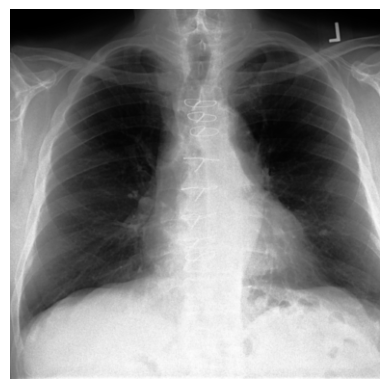

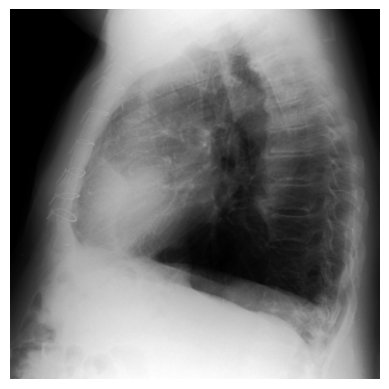

In [16]:
# Display images:
for i, j in enumerate(batch['images']):
    display(f'Study {i+1}:')
    for k in j:
        if not torch.all(k == 0):
            image = k.numpy()
            for channel in range(image.shape[0]):
                image[channel] -= image[channel].min()
                image[channel] /= image[channel].max()
            image = (image * 255).astype(np.uint8)
            plt.imshow(image.transpose(1, 2, 0), cmap='gray')
            plt.axis('off')
            plt.show()

In [17]:
len(dataset)

3677

In [18]:
type(batch)

dict

In [19]:
batch.keys()

dict_keys(['images', 'findings', 'impression'])

In [20]:
batch['findings']

['']

In [21]:
batch['impression']

['No acute cardiopulmonary process demonstrated.']

In [22]:
batch['images'].shape

torch.Size([1, 2, 3, 384, 384])

In [62]:
# If you want to *prefix* the decoder with a text prompt, encode it:
prompt_text = "[BOS] Say some thing [SEP]"
prompt_text = "[BOS] Say some thing "
prompt_ids  = tokenizer(prompt_text, return_tensors="pt").input_ids.to(device)

In [65]:
prompt_ids

tensor([[    1,   298,   396,   950, 23222,    98,     3]], device='cuda:0')

In [42]:
prompt = (
  "[BOS] Prior Study (2025-03-15): "
  "No acute cardiopulmonary abnormality. "
  "Heart and mediastinal contours are normal."
)
prompt_ids  = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
# Generate findings only:
output_ids = model.generate(
    pixel_values=batch['images'].to(device=device),
    input_ids=prompt_ids,
    max_length=512,
    num_beams=4,
    # do_sample=True,
    do_sample=False,
    # temperature=1.2,
    temperature=1.0,
    bad_words_ids=[[tokenizer.convert_tokens_to_ids('[NF]')]],
    eos_token_id=tokenizer.sep_token_id
)
findings, impression = model.split_and_decode_sections(output_ids, tokenizer)
_ = [print(f'Findings:\n\t{i}\n') for i in findings]

Findings:
	 Prior Study (2025-03-15): No acute cardiopulmonary abnormality. Heart and mediastinal contours are normal. Prominence of the pulmonary infiltrate in the left lower lobe and possible in the right upper lobe with volume loss. no pleural effusion. cardiomedastinal silhouette not increased.



In [43]:
# Generate findings only:
output_ids = model.generate(
    pixel_values=batch['images'].to(device=device),
    max_length=512,
    num_beams=4,
    do_sample=True,
    temperature=1.2,
    bad_words_ids=[[tokenizer.convert_tokens_to_ids('[NF]')]],
    eos_token_id=tokenizer.sep_token_id
)
findings, impression = model.split_and_decode_sections(output_ids, tokenizer)
_ = [print(f'Findings:\n\t{i}\n') for i in findings]

Findings:
	 reported chest. compared to the x-ray performed on the date, radiological improvement is appreciated with a decrease in the size and density of the left perihilar pulmonary opacities. right peripheral fibrous tracts and small left pleural effusion are also suggested. the rest of the study shows no changes.



In [24]:
# Generate impression only:
output_ids = model.generate(
    pixel_values=batch['images'].to(device=device),
    max_length=512,
    num_beams=4,
    do_sample=True,
    temperature=1.2,
    bad_words_ids=[[tokenizer.convert_tokens_to_ids('[NI]')]],
    input_ids=torch.tensor([[tokenizer.bos_token_id, tokenizer.convert_tokens_to_ids('[NF]'), tokenizer.sep_token_id]]*mbatch_size, device=device, dtype=torch.long),
)
findings, impression = model.split_and_decode_sections(output_ids, tokenizer)
_ = [print(f'Impression:\n\t{i}\n') for i in impression]

Impression:
	 reported cardiac silhouette. There is no appreciable right pleural effusion. There is no pneumothorax, and no pulmonary edema. Pulmonary vascular congestion has improved since the radiograph from 2 days prior, as has the pulmonary vasculature. Left pleural effusion is small if any. Left lower lobe atelectasis has improved since ___. Small right pleural effusion is unchanged. There is no pneumothorax.



In [25]:
# Generate both sections:
output_ids = model.generate(
    pixel_values=batch['images'].to(device=device),
    max_length=512,
    num_beams=4,
    do_sample=True,
    temperature=1.2,
    bad_words_ids=[[tokenizer.convert_tokens_to_ids('[NF]')], [tokenizer.convert_tokens_to_ids('[NI]')]],
)
findings, impression = model.split_and_decode_sections(output_ids, tokenizer)
_ = [print(f'Findings:\n\t{i}\nImpression:\n\t{j}\n') for i,j in zip(findings, impression)]

Findings:
	 rotated study of the left hemithorax. the rest of the study shows no changes in the bilateral interstitial infiltrates. right pleural effusion. cardiomedastinal silhouette and hila are within normal limits. no right consolidations. left rib fracture callus. conclusion: no significant change compared to the study of the date. no right pleural effusion. study compatible with covid-19 involvement. i do not see the rest of the peripheral pulmonary parenchyma in the left hemithorax. i do not see the right hemithorax in the sinus of the left lung. nodular image in the right lung could correspond to a calcified pulmonary nodule in the right lung field. no left pleural effusion is observed and the size of the cardiac silhouette is slightly smaller compared to the x-ray of the date. left rib fracture calluses. no other significant findings in the right rib cage or in the cardiomedastinal silhouette, similar to the study of date date date date date. left pleural effusion and underlyi